In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN, HSGenerator, HSDiscriminator

%cd -

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


# Developing a loss function for density loss


## Attempt 1

tensor([[2, 0],
        [3, 2],
        [2, 0],
        [1, 2],
        [3, 3],
        [1, 1],
        [3, 2],
        [0, 2],
        [2, 1],
        [3, 3],
        [2, 0],
        [2, 3],
        [3, 0],
        [1, 1],
        [1, 3],
        [3, 0],
        [2, 2],
        [0, 1],
        [0, 3],
        [3, 3],
        [1, 1],
        [1, 0],
        [1, 1],
        [0, 3],
        [1, 0],
        [0, 1],
        [1, 3],
        [0, 0],
        [1, 2],
        [2, 1],
        [1, 0],
        [1, 3],
        [1, 1],
        [3, 0],
        [2, 2],
        [2, 3],
        [2, 1],
        [0, 3],
        [0, 3],
        [1, 1],
        [1, 1],
        [1, 3],
        [2, 2],
        [3, 2],
        [3, 2],
        [2, 1],
        [1, 0],
        [0, 0],
        [3, 2],
        [2, 2]])

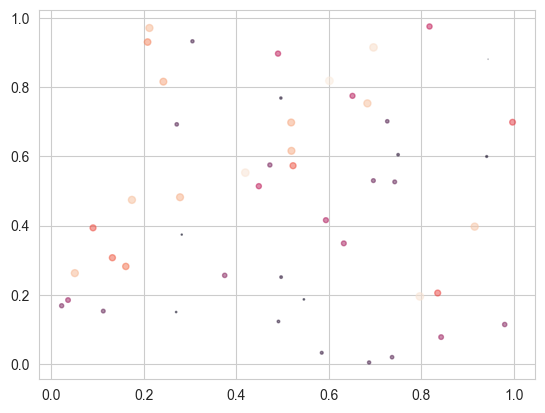

In [3]:
# Set torch random seed for reproducibility
torch.manual_seed(0)

mock_data = torch.rand([50, 3])
mock_data[:,2] *= 1

plot_pointcloud(mock_data)

def make_subgrid_mask_1d(lims, n):
    lo, hi = lims
    step = (hi - lo) / n
    grid = torch.linspace(lo+step, hi-step, steps=n-1)
    return grid

def make_subgrid_mask2d(lims_x, lims_y, n_x, n_y):
    # Break x-y in evenly distributed grid squares
    
    grid_x = make_subgrid_mask_1d(lims_x, n_x)
    grid_y = make_subgrid_mask_1d(lims_y, n_y)

    return grid_x, grid_y

def count_subgrid_density(pointcloud):
    # Expecting a pointcloud of format x,y,r

    grid_steps = 4
    lims = [0,1]

    grid_x, grid_y = make_subgrid_mask2d(lims, lims, grid_steps, grid_steps)

    # Mask the pointcloud for each step, returning a (samples, steps) matrix

    xcoords = pointcloud[:,0].unsqueeze(0)
    mask_x = (grid_x > xcoords.T).int()

    ycoords = pointcloud[:,1].unsqueeze(0)
    mask_y = (grid_y > ycoords.T).int() 

    mask_x = mask_x.sum(axis=1).unsqueeze(1)
    mask_y = mask_y.sum(axis=1).unsqueeze(1)
    grid_coordinates = torch.concat([mask_x, mask_y], dim=1)

    # count_per_grid = # TODO: Implement

    return grid_coordinates


count_subgrid_density(mock_data)


Problem: '>' and '<' operators have non-continuous gradients, which may be bad for learning.



## Attempt 2: quantiles

In [8]:
mock_data = torch.rand([50, 3])
mock_data[:3]


tensor([[0.0979, 0.5002, 0.8762],
        [0.9213, 0.5467, 0.6136],
        [0.2835, 0.8774, 0.2919]])

In [15]:
ground_truth = torch.rand([50, 3])
ground_truth.dtype

torch.float32

In [23]:

ground_truth = torch.rand([50, 3])
quantiles = torch.tensor([.05, .25, .50, .75, .95], dtype=torch.float32)
# first two columns are x and y coordinates
# Count the 5, 25, 50, 75, 95 quantiles for the first two columns and compare to the ground truth

x_q = torch.quantile(mock_data[0], quantiles)
real_q = torch.quantile(ground_truth[0], quantiles)

nn.MSELoss()(real_q, x_q)

x_q

tensor([0.1382, 0.2991, 0.5002, 0.6882, 0.8386])

In [6]:
import torch

def _non_saturating_gan_loss(fake_outputs):
        return -torch.mean(torch.log(fake_outputs))


fake_outputs = torch.tensor([.9, .9, .9, .9, .9])

_non_saturating_gan_loss(fake_outputs)

tensor(0.1054)